### Code untuk di Jupyter notebook

In [5]:
%cd D:\SEMESTER 7\Pembelajaran Mesin\Dataset\preprocess melanoma

D:\SEMESTER 7\Pembelajaran Mesin\Dataset\preprocess melanoma


In [6]:
%ls

 Volume in drive D is Data
 Volume Serial Number is BC6D-4CE5

 Directory of D:\SEMESTER 7\Pembelajaran Mesin\Dataset\preprocess melanoma

06/12/2021  14:31    <DIR>          .
06/12/2021  14:31    <DIR>          ..
30/11/2021  06:25    <DIR>          logs
22/11/2021  18:54         4.325.824 model_1.h5
22/11/2021  18:54           753.256 model_2.h5
22/11/2021  18:55            23.589 model-1-acc.svg
22/11/2021  18:54            26.334 model-1-loss.svg
06/12/2021  14:31       176.430.440 model-2-89%.h5
22/11/2021  18:54            23.600 model-2-acc.svg
22/11/2021  18:54            26.343 model-2-loss.svg
25/11/2021  17:06    <DIR>          testing
25/11/2021  17:06    <DIR>          training
25/11/2021  17:06    <DIR>          validation
               7 File(s)    181.609.386 bytes
               6 Dir(s)  968.890.171.392 bytes free


In [7]:
import os
# path di jupyter
base_dataset = 'D:/SEMESTER 7/Pembelajaran Mesin/Dataset/preprocess melanoma/'

In [8]:
# inisialisasi direktori data train dan validasi beserta data per kategori
dir1 = [r'D:/SEMESTER 7/Pembelajaran Mesin/Dataset/preprocess melanoma/training/acral melanoma/',
        r'D:/SEMESTER 7/Pembelajaran Mesin/Dataset/preprocess melanoma/validation/acral melanoma/',
        r'D:/SEMESTER 7/Pembelajaran Mesin/Dataset/preprocess melanoma/testing/acral melanoma/',
        r'D:/SEMESTER 7/Pembelajaran Mesin/Dataset/preprocess melanoma/training/benign nevi/',
        r'D:/SEMESTER 7/Pembelajaran Mesin/Dataset/preprocess melanoma/validation/benign nevi/',
        r'D:/SEMESTER 7/Pembelajaran Mesin/Dataset/preprocess melanoma/testing/benign nevi/']

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1/255,
        rotation_range=90,
        horizontal_flip=True,
        vertical_flip = True,
        zoom_range = 0.2,)

val_datagen = ImageDataGenerator(
    rescale=1/255)

test_datagen = ImageDataGenerator(
    rescale=1/255)

In [21]:
batch_size=8
train_dataset = train_datagen.flow_from_directory(batch_size=batch_size,
                                                  directory=base_dataset+'training/',
                                                  target_size=(224, 224),
                                                  class_mode='binary')

validation_dataset = val_datagen.flow_from_directory(batch_size=batch_size,
                                                     directory=base_dataset+'validation/',
                                                     target_size=(224, 224),
                                                     class_mode='binary')

test_dataset = val_datagen.flow_from_directory(batch_size=batch_size,
                                               directory=base_dataset+'testing/',
                                               target_size=(224, 224),
                                               class_mode='binary')

Found 507 images belonging to 2 classes.
Found 145 images belonging to 2 classes.
Found 72 images belonging to 2 classes.


In [22]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Concatenate
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.vgg19 import VGG19

import tensorflow as tf

In [23]:
vgg_net = VGG19(include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [24]:
dense_net201 = DenseNet201(include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [59]:
class FCHeadNet:
    def build(baseModel, classes):
        headModel = baseModel.output
        headModel = Flatten(name="flatten")(headModel)
        headModel = Dense(512, activation='relu')(headModel)
        headModel = Dropout(0.2)(headModel)
        headModel = Dense(classes, activation='sigmoid')(headModel)
        return headModel

In [60]:
headModel = FCHeadNet.build(vgg_net, 1)
model = Model(inputs=vgg_net.input, outputs=headModel)
for layer in vgg_net.layers:
    layer.trainable = False

In [61]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [62]:
from tensorflow.keras.optimizers import Adam, SGD

model.compile(optimizer=SGD(learning_rate=1e-3), 
              loss='binary_crossentropy', 
              metrics=['acc'])

In [64]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(
        monitor="val_acc",
        patience=50,
        verbose=1,
        restore_best_weights=True,
)

def scheduler(epoch, learning_rate):
    if epoch < 50:
        return learning_rate
    else:
        return learning_rate * tf.math.exp(-0.1)
    
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

history = model.fit(train_dataset, batch_size=batch_size,
                        validation_data=validation_dataset, epochs=100, callbacks = [callback])

Epoch 1/100
64/64 [==============================] - 9s 138ms/step - loss: 0.5436 - acc: 0.7396 - val_loss: 0.5508 - val_acc: 0.6966
Epoch 2/100
64/64 [==============================] - 9s 139ms/step - loss: 0.5241 - acc: 0.7554 - val_loss: 0.7176 - val_acc: 0.5310
Epoch 3/100
64/64 [==============================] - 9s 139ms/step - loss: 0.4881 - acc: 0.7554 - val_loss: 0.4283 - val_acc: 0.7655
Epoch 4/100
64/64 [==============================] - 9s 139ms/step - loss: 0.4867 - acc: 0.7732 - val_loss: 0.4034 - val_acc: 0.8621
Epoch 5/100
64/64 [==============================] - 9s 141ms/step - loss: 0.4746 - acc: 0.7909 - val_loss: 0.5258 - val_acc: 0.7517
Epoch 6/100
64/64 [==============================] - 9s 140ms/step - loss: 0.4668 - acc: 0.7751 - val_loss: 0.3880 - val_acc: 0.8069
Epoch 7/100
64/64 [==============================] - 9s 140ms/step - loss: 0.4712 - acc: 0.7850 - val_loss: 0.4046 - val_acc: 0.8414
Epoch 8/100
64/64 [==============================] - 9s 140ms/step - 

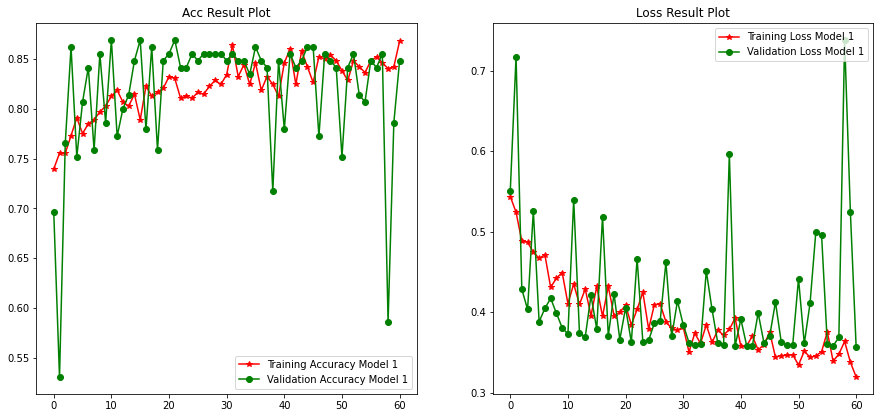

In [65]:
import matplotlib.pyplot as plt

acc_model_1 = history.history['acc']
val_acc_model_1 = history.history['val_acc']
loss_model_1 = history.history['loss']
val_los_model_1 = history.history['val_loss']

epochs_range = range(61)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc_model_1, label='Training Accuracy Model 1', color='r', marker='*')
plt.plot(epochs_range, val_acc_model_1, label='Validation Accuracy Model 1', color='g', marker='o')
plt.legend(loc='lower right')
plt.title('Acc Result Plot')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss_model_1, label='Training Loss Model 1', color='r', marker='*')
plt.plot(epochs_range, val_los_model_1, label='Validation Loss Model 1', color='g', marker='o')
plt.legend(loc='upper right')
plt.title('Loss Result Plot')
plt.show()

In [66]:
import cv2
def gather_data(dataset_dir, image_size):
    dataset_data = []
    dataset_label = []
    for r, d, f in os.walk(dataset_dir):
        for file in f:
            if ".jpg" in file:
                imagePath = os.path.join(r, file)
                image = cv2.imread(imagePath)
                image = cv2.resize(image, (image_size,image_size))
                dataset_data.append(image)
                label = imagePath.split(os.path.sep)[-2]
                dataset_label.append(label)
    dataset_data = np.array(dataset_data)
    dataset_label = np.array(dataset_label)
    return dataset_data, dataset_label

test_data, test_label = gather_data(base_dataset+'testing',224)

In [67]:
from sklearn.preprocessing import LabelEncoder

x_test = test_data.astype('float32') / 255.0

lb = LabelEncoder()
y_test = lb.fit_transform(test_label)

In [68]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
pred = model.predict(x_test)
labels = (pred > 0.5).astype(int)
target_names = ['acral melanoma', 'benign nevi']
print(classification_report(y_test, labels, target_names=target_names))

print('Confusion Matrix')
print(confusion_matrix(y_test, labels))

                precision    recall  f1-score   support

acral melanoma       0.91      0.94      0.93        34
   benign nevi       0.93      0.90      0.92        31

      accuracy                           0.92        65
     macro avg       0.92      0.92      0.92        65
  weighted avg       0.92      0.92      0.92        65

Confusion Matrix
[[32  2]
 [ 3 28]]


In [69]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('D:/SEMESTER 7/Pembelajaran Mesin/Dataset/preprocess melanoma/model1-cnn.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Fadhlan\AppData\Local\Temp\tmpo26p0mje\assets


In [70]:
class FCHeadNet2:
    def build(baseModel, classes):
        headModel = baseModel.output
        headModel = Flatten(name="flatten")(headModel)
        headModel = Dense(512, activation='relu')(headModel)
        headModel = Dropout(0.2)(headModel)
        headModel = Dense(classes, activation='sigmoid')(headModel)
        return headModel

In [71]:
headModel = FCHeadNet.build(dense_net201, 1)
model2 = Model(inputs=dense_net201.input, outputs=headModel)
for layer in dense_net201.layers:
    layer.trainable = False

model2.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [72]:
from tensorflow.keras.optimizers import Adam, SGD

model2.compile(optimizer=SGD(learning_rate=1e-3), 
              loss='binary_crossentropy', 
              metrics=['acc'])

In [73]:
callback = EarlyStopping(
        monitor="val_acc",
        patience=50,
        verbose=1,
        restore_best_weights=True,
)
    
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

history2 = model2.fit(train_dataset, batch_size=batch_size,
                        validation_data=validation_dataset, epochs=100, callbacks = [callback])

Epoch 1/100
64/64 [==============================] - 17s 153ms/step - loss: 0.4716 - acc: 0.7949 - val_loss: 0.3762 - val_acc: 0.8552
Epoch 2/100
64/64 [==============================] - 8s 118ms/step - loss: 0.2887 - acc: 0.8836 - val_loss: 0.3937 - val_acc: 0.8414
Epoch 3/100
64/64 [==============================] - 7s 115ms/step - loss: 0.2197 - acc: 0.9034 - val_loss: 0.3037 - val_acc: 0.8828
Epoch 4/100
64/64 [==============================] - 7s 115ms/step - loss: 0.1887 - acc: 0.9250 - val_loss: 0.3431 - val_acc: 0.8759TA: 1s - loss: 0.209
Epoch 5/100
64/64 [==============================] - 7s 116ms/step - loss: 0.2044 - acc: 0.9310 - val_loss: 0.3356 - val_acc: 0.8690
Epoch 6/100
64/64 [==============================] - 7s 115ms/step - loss: 0.1718 - acc: 0.9270 - val_loss: 0.3377 - val_acc: 0.8759
Epoch 7/100
64/64 [==============================] - 7s 115ms/step - loss: 0.1641 - acc: 0.9231 - val_loss: 0.3338 - val_acc: 0.8966
Epoch 8/100
64/64 [=============================

64/64 [==============================] - 8s 120ms/step - loss: 0.0453 - acc: 0.9783 - val_loss: 0.4203 - val_acc: 0.8828
Restoring model weights from the end of the best epoch.
Epoch 00060: early stopping


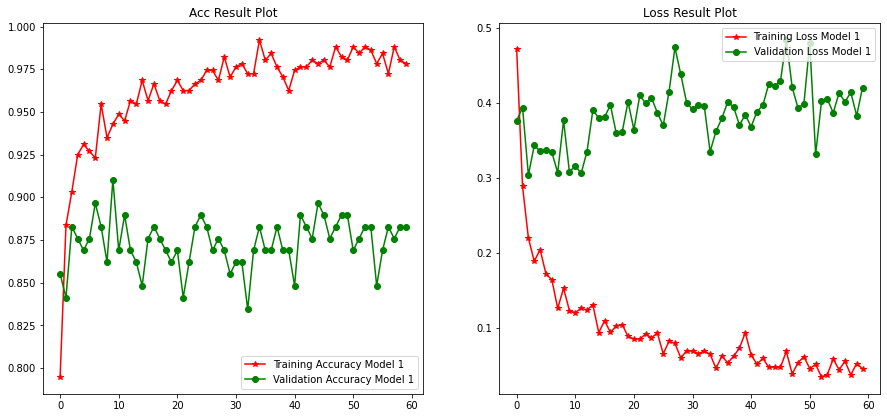

In [74]:
import matplotlib.pyplot as plt

acc_model_1 = history2.history['acc']
val_acc_model_1 = history2.history['val_acc']
loss_model_1 = history2.history['loss']
val_los_model_1 = history2.history['val_loss']

epochs_range = range(60)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc_model_1, label='Training Accuracy Model 1', color='r', marker='*')
plt.plot(epochs_range, val_acc_model_1, label='Validation Accuracy Model 1', color='g', marker='o')
plt.legend(loc='lower right')
plt.title('Acc Result Plot')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss_model_1, label='Training Loss Model 1', color='r', marker='*')
plt.plot(epochs_range, val_los_model_1, label='Validation Loss Model 1', color='g', marker='o')
plt.legend(loc='upper right')
plt.title('Loss Result Plot')
plt.show()

In [75]:
pred = model2.predict(x_test)
labels = (pred > 0.5).astype(int)
target_names = ['acral melanoma', 'benign nevi']
print(classification_report(y_test, labels, target_names=target_names))

print('Confusion Matrix')
print(confusion_matrix(y_test, labels))

                precision    recall  f1-score   support

acral melanoma       0.84      0.91      0.87        34
   benign nevi       0.89      0.81      0.85        31

      accuracy                           0.86        65
     macro avg       0.87      0.86      0.86        65
  weighted avg       0.86      0.86      0.86        65

Confusion Matrix
[[31  3]
 [ 6 25]]


In [76]:
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
tflite_model = converter.convert()

# Save the model.
with open('D:/SEMESTER 7/Pembelajaran Mesin/Dataset/preprocess melanoma/model2-cnn.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Fadhlan\AppData\Local\Temp\tmp3jsk47dq\assets


INFO:tensorflow:Assets written to: C:\Users\Fadhlan\AppData\Local\Temp\tmp3jsk47dq\assets


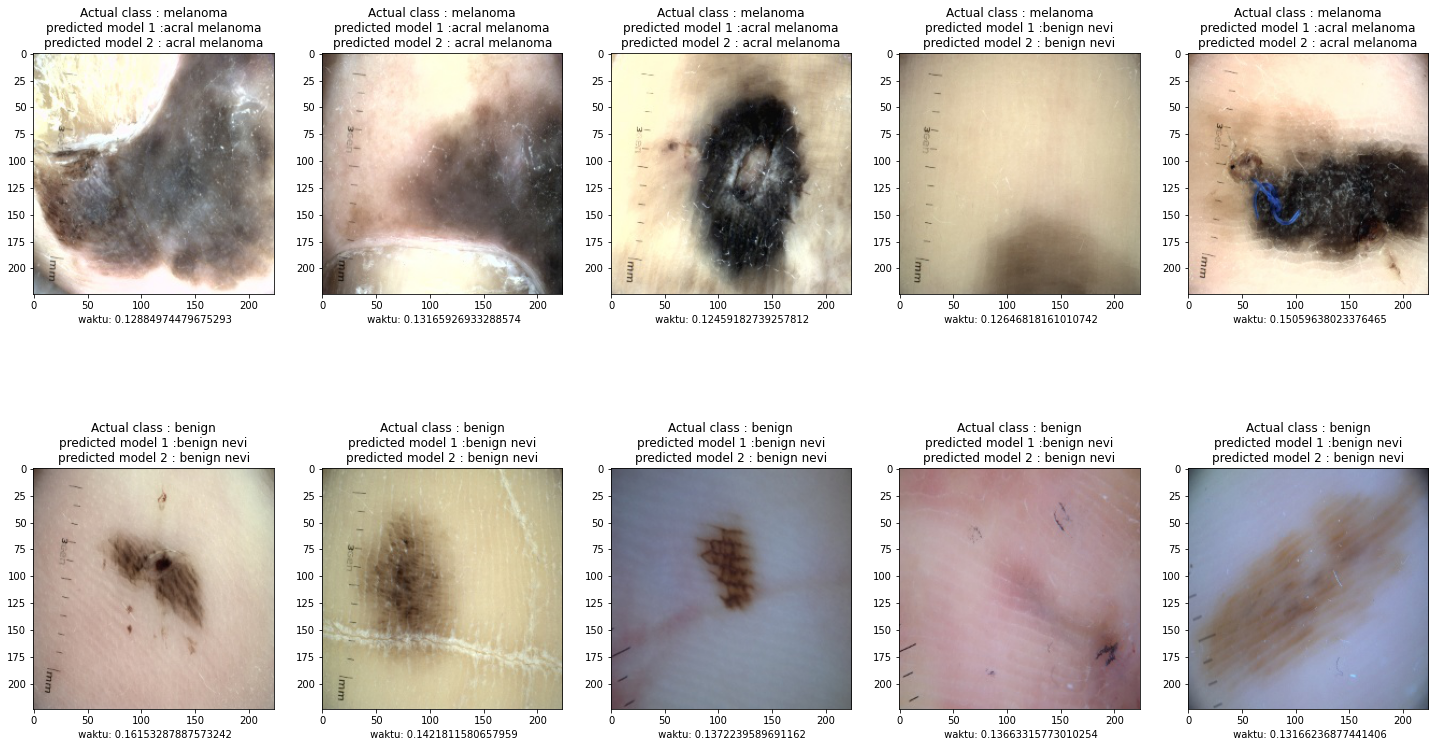

In [80]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from PIL import Image

def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    img_arr = (np.array(nimg))/255
    return img_arr

def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

nrows = 2
ncols = 5
input_size = (224, 224)
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 5, nrows * 7)

pic_index += 10
melanoma_pix = [os.path.join(dir1[2], fname) for fname in os.listdir(dir1[2])[:5]]
benign_pix = [os.path.join(dir1[5], fname) for fname in os.listdir(dir1[5])[:5]]

for i, img_path in enumerate(melanoma_pix+benign_pix):
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)

    labels = ['acral melanoma', 'benign nevi']
    im = Image.open(img_path)
    X = preprocess(im,input_size)
    X = reshape([X])

    start = time.time()
    y = model.predict(X)
    z = model2.predict(X)
    waktu = time.time() - start

    if i < 5:
        plt.title('Actual class : melanoma\n'+'predicted model 1 :'+labels[int(np.round(y, 0))]+ '\n' + 'predicted model 2 : ' +labels[int(np.round(z, 0))])
        plt.xlabel(' waktu: ' + str(waktu))
    else:
        plt.title('Actual class : benign\n'+'predicted model 1 :'+labels[int(np.round(y, 0))]+ '\n' + 'predicted model 2 : ' +labels[int(np.round(z, 0))])
        plt.xlabel(' waktu: ' + str(waktu))

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()